<a target="_blank" href="https://colab.research.google.com/github/elliottabe/mujoco_workshop2024/blob/main/Introduction01.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mujoco
!pip install mujoco_mjx
!pip install brax

In [1]:

# Set up GPU rendering.
# from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# # This is usually installed as part of an Nvidia driver package, but the Colab
# # kernel doesn't install its driver via APT, and as a result the ICD is missing.
# # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
# NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
# if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
#   with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
#     f.write("""{
#     "file_format_version" : "1.0.0",
#     "ICD" : {
#         "library_path" : "libEGL_nvidia.so.0"
#     }
# }
# """)

# # Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()


MuJoCo stands for **Mu**lti-**Jo**int dynamics with **Co**ntact. It is a general purpose physics engine that aims to facilitate research and development in robotics, biomechanics, graphics and animation, machine learning, and other areas that demand fast and accurate simulation of articulated structures interacting with their environment. 

Key Features of MuJoCo: 
 - Generalized coordinates combined with modern contact dynamics
 - Soft, convex and analytically-invertible contact dynamics
 - Tendon geometry
 - General actuation model
 - Reconfigurable computation pipeline
 - Model compilation
 - Separation of model and data
 - Interactive simulation and visualization
 - Powerful yet intuitive modeling language
 - Automated generation of composite flexible objects

Workflow Overview
 - The workflow MuJoCo starts with a user defined XML file that specifies the model and environment at compilation time. 
 - MuJoCo is written in C/C++ but has python binding for additional devleopment
 - There are two main stuctures in MujoCo: 
   - mjModel: specifies the kinematic tree for calculating collisions and forces
   - mjData: specifies simulated state of the model and enviornment

<img align="left" src="Images/workflow.png" alt="drawing" width="300"/>
<!-- &nbsp;  -->
<img src="Images/kinematic_tree.png" alt="drawing" height="300"/>
<img src="Images/simulated_state.png" alt="drawing" height="300"/>

In [2]:
from dm_control import mjcf
from IPython.display import HTML
import PIL.Image

In [7]:
class Leg(object):
  """A 2-DoF leg with position actuators."""
  def __init__(self, length, rgba):
    self.model = mjcf.RootElement()

    # Defaults:
    self.model.default.joint.damping = 2
    self.model.default.joint.type = 'hinge'
    self.model.default.geom.type = 'capsule'
    self.model.default.geom.rgba = rgba  # Continued below...

    # Thigh:
    self.thigh = self.model.worldbody.add('body')
    self.hip = self.thigh.add('joint', axis=[0, 0, 1])
    self.thigh.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/4])

    # Hip:
    self.shin = self.thigh.add('body', pos=[length, 0, 0])
    self.knee = self.shin.add('joint', axis=[0, 1, 0])
    self.shin.add('geom', fromto=[0, 0, 0, 0, 0, -length], size=[length/5])

    # Position actuators:
    self.model.actuator.add('position', joint=self.hip, kp=10)
    self.model.actuator.add('position', joint=self.knee, kp=10)

In [4]:
BODY_RADIUS = 0.1
BODY_SIZE = (BODY_RADIUS, BODY_RADIUS, BODY_RADIUS / 2)
random_state = np.random.RandomState(42)

def make_creature(num_legs):
  """Constructs a creature with `num_legs` legs."""
  rgba = random_state.uniform([0, 0, 0, 1], [1, 1, 1, 1])
  model = mjcf.RootElement()
  model.compiler.angle = 'radian'  # Use radians.

  # Make the torso geom.
  model.worldbody.add(
      'geom', name='torso', type='ellipsoid', size=BODY_SIZE, rgba=rgba)

  # Attach legs to equidistant sites on the circumference.
  for i in range(num_legs):
    theta = 2 * i * np.pi / num_legs
    hip_pos = BODY_RADIUS * np.array([np.cos(theta), np.sin(theta), 0])
    hip_site = model.worldbody.add('site', pos=hip_pos, euler=[0, 0, theta])
    leg = Leg(length=BODY_RADIUS, rgba=rgba)
    hip_site.attach(leg.model)

  return model

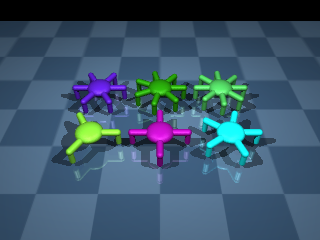

In [8]:
#@title Six Creatures on a floor.{vertical-output: true}

arena = mjcf.RootElement()
chequered = arena.asset.add('texture', type='2d', builtin='checker', width=300,
                            height=300, rgb1=[.2, .3, .4], rgb2=[.3, .4, .5])
grid = arena.asset.add('material', name='grid', texture=chequered,
                       texrepeat=[5, 5], reflectance=.2)
arena.worldbody.add('geom', type='plane', size=[2, 2, .1], material=grid)
for x in [-2, 2]:
  arena.worldbody.add('light', pos=[x, -1, 3], dir=[-x, 1, -2])

# Instantiate 6 creatures with 3 to 8 legs.
creatures = [make_creature(num_legs=num_legs) for num_legs in range(3, 9)]

# Place them on a grid in the arena.
height = .15
grid = 5 * BODY_RADIUS
xpos, ypos, zpos = np.meshgrid([-grid, 0, grid], [0, grid], [height])
for i, model in enumerate(creatures):
  # Place spawn sites on a grid.
  spawn_pos = (xpos.flat[i], ypos.flat[i], zpos.flat[i])
  spawn_site = arena.worldbody.add('site', pos=spawn_pos, group=3)
  # Attach to the arena at the spawn sites, with a free joint.
  spawn_site.attach(model).add('freejoint')

# Instantiate the physics and render.
physics = mjcf.Physics.from_mjcf_model(arena)
PIL.Image.fromarray(physics.render())

In [10]:
#@title Import MuJoCo, MJX, and Brax
from datetime import datetime
from etils import epath
import functools
from IPython.display import HTML
import PIL.Image
from typing import Any, Dict, Sequence, Tuple, Union
import os
from ml_collections import config_dict

import jax
from jax import numpy as jp
import numpy as np
from flax.training import orbax_utils
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from orbax import checkpoint as ocp

import mujoco
from mujoco import mjx

from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, PipelineEnv, State
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import html, mjcf, model
